Let's parse through a list of 100k smiles tokens from the CHEMBL database. fragment_wild.py will find the cuttable bonds and denote them. We can later separate these into fragments.

In [1]:
import subprocess

# Define the command as a list of strings
command = ["python", "../src/fragment_wild.py", "--seed", "42", "-o", "../data/output.txt", "-i", "../data/CHEMBL_100k.smi/CHEMBL_100k.smi", "-n", "1", "-w", "150"]

# Call the command and capture output
result = subprocess.run(command, check=False, stdout=subprocess.PIPE, stderr=subprocess.PIPE)

# Print the standard output and standard error
print("STDOUT:\n", result.stdout.decode())
print("STDERR:\n", result.stderr.decode())

STDOUT:
 
STDERR:
 


You should now see a file called output.smi in the data folder. Lets now break those molecules into fragments based on the indicated breakable bonds.

In [2]:
import pandas as pd

# Function to read the file and parse its contents into a DataFrame
def parse_smiles_file_from_path(file_path):
    # Read the file contents
    with open(file_path, 'r') as file:
        lines = file.readlines()

    # Parse each line into (smiles, CHEMBLID, cut_bonds)
    data = []
    for line in lines:
        parts = line.strip().split('\t')
        if len(parts) >= 3:
            smiles = parts[0]
            chembl_id = parts[1]
            cut_bonds = [int(bond.strip()) for bond in parts[2].split()]
            data.append((smiles, chembl_id, cut_bonds))
    
    # Load the data into a DataFrame
    df = pd.DataFrame(data, columns=['SMILES', 'CHEMBLID', 'Cut Bonds'])
    return df

# Path to your file
file_path = "../data/output.txt"

# Parse the file and load its contents into a DataFrame
df = parse_smiles_file_from_path(file_path)
df

C:\Users\patri\AppData\Local\Temp\ipykernel_18276\238208871.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


,SMILES,CHEMBLID,Cut Bonds
0,Cc1ccc(/C=C(\C#N)n2nnc3cnccc32)cc1,CHEMBL4166148,[6]
1,N#C/C(=C\c1ccc(-c2cc(Cl)ccc2Cl)o1)C(=O)Nc1cccc...,CHEMBL224864,"[18, 16]"
2,Nc1n[nH]c2c(-c3ccc(NC(=O)c4ccccc4)cc3)ncc(-c3c...,CHEMBL3657216,"[11, 10]"
3,CCOC(=O)C1=C(N/N=C(\C(C)=O)C(=O)c2ccccc2)Nc2[n...,CHEMBL4293891,"[32, 9]"
4,CCNC(=O)N1CCS(=O)(=Nc2cc(C)c3c(Nc4ccc(F)cc4O[C...,CHEMBL4108901,"[26, 24, 9]"
...,...,...,...
96250,CC(=O)c1ccc(CNC(=O)c2cc(C#N)cn2C)nc1C,CHEMBL3468660,[13]
96251,O=c1cccccc1NCCCCCCCCNc1cccccc1=O,CHEMBL1976953,[15]
96252,Cn1ncc(Br)c1NC(=O)Nc1ccc(OC(F)(F)F)cc1,CHEMBL1579554,"[8, 14]"
96253,CC(C)=CCCOc1cc(OCCC=C(C)C)c2ccccc2n1,CHEMBL1090590,[11]


In [3]:
import pandas as pd
from rdkit import Chem
from rdkit.Chem import rdmolops

def fragment_molecule_on_bonds(smiles, bond_indices):
    mol = Chem.MolFromSmiles(smiles)
    fragmented_mol = rdmolops.FragmentOnBonds(mol, bond_indices)
    fragment_smiles = Chem.MolToSmiles(fragmented_mol).split('.')
    return fragment_smiles

# Assuming df is your existing DataFrame
# Initialize a list to store the new rows
fragment_data = []

# Iterate over the rows in the DataFrame
for index, row in df.iterrows():
    original_smiles = row['SMILES']
    chembl_id = row['CHEMBLID']
    bond_indices = row['Cut Bonds']
    
    # Generate the fragments
    fragments = fragment_molecule_on_bonds(original_smiles, bond_indices)
    
    # Add a row for each fragment
    for fragment in fragments:
        fragment_data.append([original_smiles, fragment, chembl_id])

# Create the new DataFrame
fragment_df = pd.DataFrame(fragment_data, columns=["Original SMILES", "Fragment SMILES", "CHEMBLID"])


In [4]:
fragment_df

,Original SMILES,Fragment SMILES,CHEMBLID
0,Cc1ccc(/C=C(\C#N)n2nnc3cnccc32)cc1,[6*]C#N,CHEMBL4166148
1,Cc1ccc(/C=C(\C#N)n2nnc3cnccc32)cc1,[7*]/C(=C\c1ccc(C)cc1)n1nnc2cnccc21,CHEMBL4166148
2,N#C/C(=C\c1ccc(-c2cc(Cl)ccc2Cl)o1)C(=O)Nc1cccc...,[17*]/C(C#N)=C/c1ccc(-c2cc(Cl)ccc2Cl)o1,CHEMBL224864
3,N#C/C(=C\c1ccc(-c2cc(Cl)ccc2Cl)o1)C(=O)Nc1cccc...,[17*]Nc1cccc2ncccc12,CHEMBL224864
4,N#C/C(=C\c1ccc(-c2cc(Cl)ccc2Cl)o1)C(=O)Nc1cccc...,[2*]C([19*])=O,CHEMBL224864
...,...,...,...
282631,CC(C)=CCCOc1cc(OCCC=C(C)C)c2ccccc2n1,[11*]CC=C(C)C,CHEMBL1090590
282632,CC(C)=CCCOc1cc(OCCC=C(C)C)c2ccccc2n1,[12*]COc1cc(OCCC=C(C)C)nc2ccccc12,CHEMBL1090590
282633,CC(=O)c1ccc(S(=O)(=O)Nc2ccc(-c3ccc4nnc(C)n4n3)...,[21*]C,CHEMBL1457702
282634,CC(=O)c1ccc(S(=O)(=O)Nc2ccc(-c3ccc4nnc(C)n4n3)...,[7*]=O,CHEMBL1457702


Lets take a look at some of these fragments

                                     Original SMILES  \
0                 Cc1ccc(/C=C(\C#N)n2nnc3cnccc32)cc1   
1                 Cc1ccc(/C=C(\C#N)n2nnc3cnccc32)cc1   
2  N#C/C(=C\c1ccc(-c2cc(Cl)ccc2Cl)o1)C(=O)Nc1cccc...   
3  N#C/C(=C\c1ccc(-c2cc(Cl)ccc2Cl)o1)C(=O)Nc1cccc...   
4  N#C/C(=C\c1ccc(-c2cc(Cl)ccc2Cl)o1)C(=O)Nc1cccc...   

                           Fragment SMILES       CHEMBLID  
0                                  [6*]C#N  CHEMBL4166148  
1      [7*]/C(=C\c1ccc(C)cc1)n1nnc2cnccc21  CHEMBL4166148  
2  [17*]/C(C#N)=C/c1ccc(-c2cc(Cl)ccc2Cl)o1   CHEMBL224864  
3                     [17*]Nc1cccc2ncccc12   CHEMBL224864  
4                           [2*]C([19*])=O   CHEMBL224864  


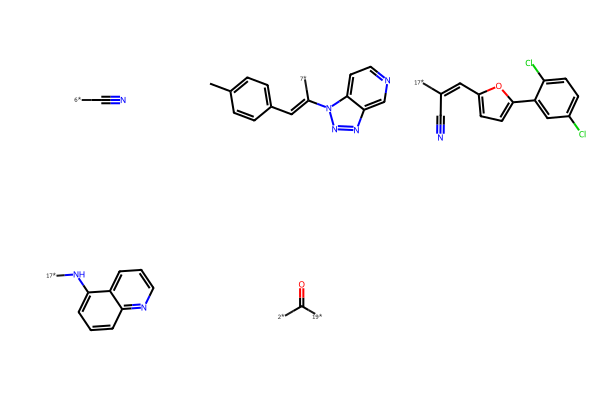

In [5]:
from rdkit import Chem
from rdkit.Chem import Draw

# Display the first 5 rows of fragment_df
print(fragment_df.head())

# Convert the first 5 SMILES strings to RDKit Mol objects
molecules = [Chem.MolFromSmiles(smiles) for smiles in fragment_df['Fragment SMILES'].head(5)]

# Draw the molecules
Draw.MolsToGridImage(molecules)

Looks good. However, we cannot have the placeholder atoms (e.g. [7*]) in the SMILES strings for mestReNova. Lets remove them.

In [6]:
import re

# Function to clean SMILES strings and add a carbon atom to leading double bonds
def clean_and_modify_smiles(smiles_string):
    # Remove wildcard atoms
    smiles_string = re.sub(r'\[\d+\*\]', '', smiles_string)
    # Remove leading forward slashes
    smiles_string = re.sub(r'^/', '', smiles_string)
    # If the string leads with '=', prepend it with a 'C'
    # Remove leading *
    smiles_string = re.sub(r'^\*', '', smiles_string)
    if smiles_string.startswith('='):
        smiles_string = 'C' + smiles_string
    return smiles_string

# Apply the function to clean and modify the 'Fragment SMILES' column
fragment_df['Fragment SMILES'] = fragment_df['Fragment SMILES'].apply(clean_and_modify_smiles)
fragment_df


# Function to filter the DataFrame based on minimum length of 'Fragment SMILES'
def filter_by_min_length(df, min_length):
    # Filtering out rows where the length of 'Fragment SMILES' is less than min_length
    return df[df['Fragment SMILES'].str.len() >= min_length]

# Example usage: Filter out fragments where the length is less than 3 characters
min_length = 6
filtered_df = filter_by_min_length(fragment_df, min_length)

filtered_df





,Original SMILES,Fragment SMILES,CHEMBLID
1,Cc1ccc(/C=C(\C#N)n2nnc3cnccc32)cc1,C(=C\c1ccc(C)cc1)n1nnc2cnccc21,CHEMBL4166148
2,N#C/C(=C\c1ccc(-c2cc(Cl)ccc2Cl)o1)C(=O)Nc1cccc...,C(C#N)=C/c1ccc(-c2cc(Cl)ccc2Cl)o1,CHEMBL224864
3,N#C/C(=C\c1ccc(-c2cc(Cl)ccc2Cl)o1)C(=O)Nc1cccc...,Nc1cccc2ncccc12,CHEMBL224864
5,Nc1n[nH]c2c(-c3ccc(NC(=O)c4ccccc4)cc3)ncc(-c3c...,C(=)c1ccccc1,CHEMBL3657216
7,Nc1n[nH]c2c(-c3ccc(NC(=O)c4ccccc4)cc3)ncc(-c3c...,Nc1ccc(-c2ncc(-c3ccc(Oc4ccccc4)cc3)c3c(N)n[nH]...,CHEMBL3657216
...,...,...,...
282628,Cn1ncc(Br)c1NC(=O)Nc1ccc(OC(F)(F)F)cc1,OC(F)(F)F,CHEMBL1579554
282630,Cn1ncc(Br)c1NC(=O)Nc1ccc(OC(F)(F)F)cc1,C=C(Nc1ccc()cc1)Nc1c(Br)cnn1C,CHEMBL1579554
282631,CC(C)=CCCOc1cc(OCCC=C(C)C)c2ccccc2n1,CC=C(C)C,CHEMBL1090590
282632,CC(C)=CCCOc1cc(OCCC=C(C)C)c2ccccc2n1,COc1cc(OCCC=C(C)C)nc2ccccc12,CHEMBL1090590


Lets now write the fragment SMILES to a .csv file for mestReNova

In [7]:
# Extracting the 'Fragment SMILES' column from the DataFrame and resetting its index
output_df = filtered_df[['Fragment SMILES']].reset_index(drop=True)
output_df.columns = ['Smiles']  # Renaming the column to 'Smiles'

# Saving the DataFrame to a CSV file
output_csv_path = '../data/fragment_smiles.csv'
output_df.to_csv(output_csv_path, index=True, index_label='')

output_csv_path



'../data/fragment_smiles.csv'

Now lets call the mestReNova Simulation (run_mestrenova_simulation.py)

In [8]:

import psutil

# Define the command as a list of strings
command = [
    "python", 
    "C:\\Users\\patri\\OneDrive\\Desktop\\NMR_GAN\\nmr-to-structure\\src\\nmr_to_structure\\nmr_generation\\run_mestrenova_simulation.py", 
    "--smiles_csv", "C:\\Users\\patri\\OneDrive\\Desktop\\NMR_GAN\\data\\fragment_smiles.csv", 
    "--out_folder", "C:\\Users\\patri\\OneDrive\\Desktop\\NMR_GAN\\data", 
    "--sim_type", "1H", 
    "--chunk_size", "1", 
    "--start_index", "0", 
    "--mnova_path", "C:\\Program Files\\Mestrelab Research S.L\\MestReNova\\MestReNova.exe", 
    "--script_path", "C:\\Program Files\\Mestrelab Research S.L\\MestReNova\\scripts"
]


# Call the command and capture output
result = subprocess.run(command, check=False, stdout=subprocess.PIPE, stderr=subprocess.PIPE)

# Print the standard output and standard error
print("STDOUT:\n", result.stdout.decode())
print("STDERR:\n", result.stderr.decode())


or in the terminal: python "C:\Users\patri\OneDrive\Desktop\NMR_GAN\nmr-to-structure\src\nmr_to_structure\nmr_generation\run_mestrenova_simulation.py" --smiles_csv "C:\Users\patri\OneDrive\Desktop\NMR_GAN\data\fragment_smiles.csv" --out_folder "C:\Users\patri\OneDrive\Desktop\NMR_GAN\data" --sim_type type --chunk_size 100 --start_index 0 --mnova_path "C:\Program Files\Mestrelab Research S.L\MestReNova\MestReNova.exe" --script_path "C:\Program Files\Mestrelab Research S.L\MestReNova\scripts"